# Econ570--assignment2

Name: Qihui Du
USCID: 4115-8356-08

In [37]:
import pandas as pd
import numpy as np
import random
import statsmodels.api as sm
import matplotlib.pyplot as plt
import networkx as nx

In [90]:
def fn_generate_data(tau,N,p,p0,corr,conf = True,flagX = False):
    nvar = p+2 # 1 confounder and variable for randomizing treatment
    corr = 0.5 # correlation for multivariate normal
    conf_mult=1
    if conf==False:
        conf_mult = 0 # remove confounder from outcome
    allX = fn_generate_multnorm(N,corr,nvar)
    W0 = allX[:,0].reshape([N,1]) # variable for RDD assignment
    C = allX[:,1].reshape([N,1]) # confounder
    X = allX[:,2:] # observed covariates
    
    T = fn_randomize_treatment(N) # choose treated units
    err = np.random.normal(0,1,[N,1])
    beta0 = np.random.normal(5,5,[p,1])
    
    beta0[p0:p] = 0 # sparse model
    Yab = tau*T+X@beta0+conf_mult*0.6*C+err
    if flagX==False:
        return (Yab,T)
    else:
        return (Yab,T,X)

In [86]:
def fn_tauhat_means(Yt,Yc):
    nt = len(Yt)
    nc = len(Yc)
    tauhat = np.mean(Yt)-np.mean(Yc)
    se_tauhat = (np.var(Yt,ddof=1)/nt+np.var(Yc,ddof=1)/nc)**(1/2)
    return (tauhat,se_tauhat)

In [87]:
def fn_bias_rmse_size(theta0,thetahat,se_thetahat,cval = 1.96):
    b = thetahat - theta0
    bias = np.mean(b)
    rmse = np.sqrt(np.mean(b**2))
    tval = b/se_thetahat # paramhat/se_paramhat H0: theta = 0
    size = np.mean(1*(np.abs(tval)>cval))
    # note size calculated at true parameter value
    return (bias,rmse,size)

# question 1

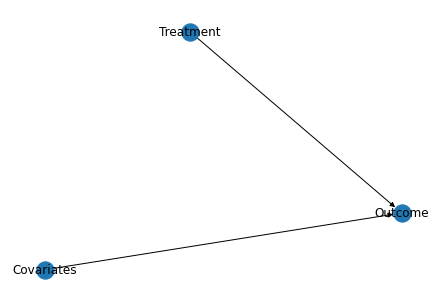

In [38]:
#showing DGP with DAG
G = nx.DiGraph()
    
G.add_node('s1', desc='Outcome')
G.add_node('s2', desc='Treatment')
G.add_node('s3', desc='Covariates')
G.add_edge('s2','s1')
G.add_edge('s3','s1')
    
pos = nx.spring_layout(G)
nx.draw(G, pos)
node_labels = nx.get_node_attributes(G, 'desc')
nx.draw_networkx_labels(G, pos, labels=node_labels)
plt.show()

# a.no covariates

𝑦𝑖=𝜏∗𝑇𝑖+𝑒𝑖


In [91]:
tau = 4
corr = .75
conf=False
p = 100
p0 = 0 # number of covariates used in the DGP
flagX=1
N=1000
Y,T,X=fn_generate_data(tau,N,p,p0,corr,conf,flagX)

In [92]:
#Run R Monte Carlo iterations and compute bias, RMSE and size¶
##not control covariates
estDict = {}
R = 2000
for N in [100,1000]:
    tauhats = []
    sehats = []
    for r in tqdm(range(R)):
        Yexp,T,X = fn_generate_data(tau,N,p,p0,corr,conf,flagX)
        Yt = Yexp[np.where(T==1)[0],:]
        Yc = Yexp[np.where(T==0)[0],:]
        tauhat,se_tauhat = fn_tauhat_means(Yt,Yc)
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]
    estDict[N] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])
    }

100%|███████████████████████████████████████| 2000/2000 [00:20<00:00, 98.85it/s]


In [93]:
tau0 = tau*np.ones([R,1])
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                         results['sehat'])
    print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')

N=100: bias=-0.006727812447516783, RMSE=0.20277890511939264, size=0.051
N=1000: bias=0.0017308767687602338, RMSE=0.06282377747567858, size=0.0435


# b.control for covariates
𝑦𝑖=𝜏∗𝑇𝑖+𝛽′∗𝑥𝑖+𝑒𝑖


In [94]:
tau = 4
corr = .75
conf=False
p = 100
p0 = 10 # number of covariates used in the DGP
N = 1000
Y,T,X = fn_generate_data(tau,N,p,p0,corr,conf,flagX)

In [96]:
#Run R Monte Carlo iterations and compute bias, RMSE and size¶
##control covariates
estDict = {}
R = 2000
for N in [100,1000]:
    tauhats = []
    sehats = []
    for r in tqdm(range(R)):
        Y,T,X = fn_generate_data(tau,N,p,p0,corr,conf,flagX)
        Xobs = X[:,:p0]
        covars = np.concatenate([T,Xobs],axis = 1)
        mod = sm.OLS(Y,covars)
        res = mod.fit()
        tauhat = res.params[0]
        se_tauhat = res.HC1_se[0]
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]
        
    estDict[N] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])
    }

100%|███████████████████████████████████████| 2000/2000 [00:21<00:00, 94.41it/s]


In [97]:
tau0 = tau*np.ones([R,1])
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                         results['sehat'])
    print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')

N=100: bias=-0.002196587652829789, RMSE=0.15209743544034957, size=0.0635
N=1000: bias=-0.0017332884322590507, RMSE=0.04446708837145685, size=0.051


# question2

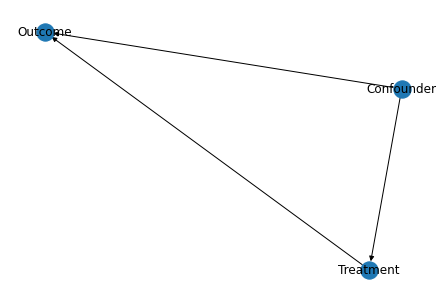

In [44]:
#showing DGP with DAG
G = nx.DiGraph()
    
G.add_node('s1', desc='Outcome')
G.add_node('s2', desc='Treatment')
G.add_node('s3', desc='Confounder')
G.add_edge('s2','s1')
G.add_edge('s3','s2')
G.add_edge('s3','s1')
    
pos = nx.spring_layout(G)
nx.draw(G, pos)
node_labels = nx.get_node_attributes(G, 'desc')
nx.draw_networkx_labels(G, pos, labels=node_labels)
plt.show()

# a.fail to control confounder

In [98]:
def fn_generate_data_conf(tau,N,p,corr):

    nvar = p+1 
    corr = 0.5 # correlation for multivariate normal
    X = fn_generate_multnorm(N,corr,nvar)
    C = X[:,1].reshape([N,1]) # confounder
    T = fn_randomize_treatment(N) # choose treated units
    err = np.random.normal(0,1,[N,1])
    Yab = tau*T+0.5*C+err
    Tab = T+0.5*C

    return (Yab,Tab,C)

In [58]:
tau = 4
corr = .75
p = 4
Y,T,C = fn_generate_data_conf(tau,N,p,corr)

In [59]:
#Run R Monte Carlo iterations and compute bias, RMSE and size¶
## Not control confounder
estDict = {}
R = 2000
for N in [100,1000]:
    tauhats = []
    sehats = []
    for r in tqdm(range(R)):
        Y,T,C = fn_generate_data_conf(tau,N,p,corr)
        covars = np.concatenate([T],axis = 1)
        mod = sm.OLS(Y,covars)
        res = mod.fit()
        tauhat = res.params[0]
        se_tauhat = res.HC1_se[0]
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]
    estDict[N] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])
    }

100%|██████████████████████████████████████| 2000/2000 [00:10<00:00, 195.69it/s]


In [61]:
tau0 = tau*np.ones([R,1])
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                         results['sehat'])
    print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')

N=100: bias=-0.9726572119552913, RMSE=1.0135236188748464, size=0.9805
N=1000: bias=-0.9742616957815742, RMSE=1.0050833012434064, size=0.999


# b.control for confounder

In [63]:
#Run R Monte Carlo iterations and compute bias, RMSE and size¶
## control for confounder
estDict = {}
R = 2000
for N in [100,1000]:
    tauhats = []
    sehats = []
    for r in tqdm(range(R)):
        Y,T,C = fn_generate_data_conf(tau,N,p,corr)
        covars = np.concatenate([T,C],axis = 1)
        mod = sm.OLS(Y,covars)
        res = mod.fit()
        tauhat = res.params[0]
        se_tauhat = res.HC1_se[0]
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]
        
    estDict[N] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])
    }

100%|██████████████████████████████████████| 2000/2000 [00:10<00:00, 189.62it/s]


In [65]:
tau0 = tau*np.ones([R,1])
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                         results['sehat'])
    print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')

N=100: bias=-0.003927498371269837, RMSE=0.14610486452880636, size=0.06
N=1000: bias=0.0014702806406225227, RMSE=0.04518728182098808, size=0.055


# question3

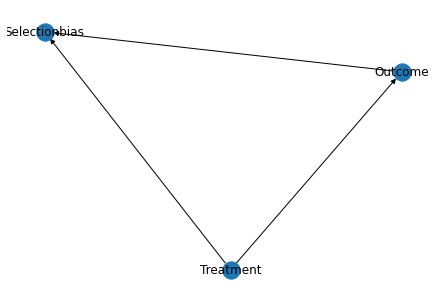

In [67]:
#showing DGP with DAG
G = nx.DiGraph()
    
G.add_node('s1', desc='Outcome')
G.add_node('s2', desc='Treatment')
G.add_node('s3', desc='Selectionbias')
G.add_edge('s2','s1')
G.add_edge('s1','s3')
G.add_edge('s2','s3')
    
pos = nx.spring_layout(G)
nx.draw(G, pos)
node_labels = nx.get_node_attributes(G, 'desc')
nx.draw_networkx_labels(G, pos, labels=node_labels)
plt.show()

# a. not control the variable between the path from cause to effect

In [69]:
def fn_generate_data_s(tau,N,p,corr):

    nvar = p+1 # 1 for selection bias
    corr = 0.5 # correlation for multivariate normal
 
    allX = fn_generate_multnorm(N,corr,nvar)
    T = fn_randomize_treatment(N) # choose treated units
    err = np.random.normal(0,1,[N,1])
    U = np.random.normal(0,1,[N,1])
    Y = tau*T+err
    S = 0.5*T+0.5*Y+U

    return (Y,T,S)

In [71]:
tau = 4
corr = 0.75
p = 4
N = 1000
Y,T,S = fn_generate_data_s(tau,N,p,corr)

In [73]:
#Run R Monte Carlo iterations and compute bias, RMSE and size
## not control selection bias
estDict = {}
R = 2000
for N in [100,1000]:
    tauhats = []
    sehats = []
    for r in tqdm(range(R)):
        Yexp,T,Z = fn_generate_data_s(tau,N,p,corr)   
        Yt = Yexp[np.where(T==1)[0],:]
        Yc = Yexp[np.where(T==0)[0],:]
        tauhat,se_tauhat = fn_tauhat_means(Yt,Yc)
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]
        
    estDict[N] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])
    }

100%|██████████████████████████████████████| 2000/2000 [00:09<00:00, 204.70it/s]


In [75]:
tau0 = tau*np.ones([R,1])
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                         results['sehat'])
    print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')

N=100: bias=0.004386010025001007, RMSE=0.19807713249004313, size=0.0445
N=1000: bias=0.0008839863187820738, RMSE=0.06231463230823513, size=0.0415


# b.control the variable between the path from cause to effect

In [77]:
#Run R Monte Carlo iterations and compute bias, RMSE and size
## control selection bias
estDict = {}
R = 2000
for N in [100,1000]:
    tauhats = []
    sehats = []
    for r in tqdm(range(R)):
        Yexp,T,Z = fn_generate_data_s(tau,N,p,corr)
        covars = np.concatenate([T,Z],axis = 1)
        mod = sm.OLS(Yexp,covars)
        res = mod.fit()
        tauhat = res.params[0]
        se_tauhat = res.HC1_se[0]
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]
        
    estDict[N] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])
    }

100%|██████████████████████████████████████| 2000/2000 [00:10<00:00, 184.23it/s]


In [78]:
tau0 = tau*np.ones([R,1])
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                         results['sehat'])
    print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')

N=100: bias=-0.9977797725753681, RMSE=1.0256157016573932, size=0.986
N=1000: bias=-0.999350610160649, RMSE=1.0021835876380296, size=1.0


# summary

I select the first three questions:with covariates, DGP with a confounder, and DGP with selection bias.
To sum up my coding and analysis, I did the following parts:

firstly, I defined several basic functions that will be useful later; 
then for the first question:
concerning with controlling for covariates, which are other factors ,maybe contributing to the outcome. For example, if we take providing a health care programme as treatment and their spending on health on yearly basis as outcome, there will definitely be other covariates contributing to the outcome, something like age, height adn sex. In our monte carlo iterations run before, we can see that the bias went down after controlling for othe covariates.

For the second question:
concerning counfounding problems, we are basically discussing covariates which may have effects not only on the outcome, but may influence the treatment then the outcome as well. For example, if we are discussing the workers productivity as outcome and we use workers;s education level as the main independent variable, however, there must be some othe characteristics like personal ambition, home wealth, etc. which linked to both education level and productivity.

For the third question:
concerning for the selection bias problem, for example, if our objective is to figure out the price premium for living on Main Street in Santa Monica and we are only taking two factors accountng for prices--location and apartment size, in this experiment, size is obviously a variable which could cause a bias if omitted, very likely causing underestimation if we leave this behind.
